In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 

In [2]:
# SMS are saved in text file names 'smss'
messages=[line.rstrip() for line in open('smss')]
# Can use .strip(), .lstrip()

In [4]:
len(messages)

5574

In [17]:
for sms_no, x in enumerate(messages):
    print sms_no, x

 0 label
1 message


In [15]:
messages = pd.read_csv('smss', sep='\t', names = ['label','message'])
print messages.head(2)

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...


In [18]:
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

In [19]:
messages['length']=messages['message'].map(lambda text: len(text))

In [20]:
print messages.head()

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


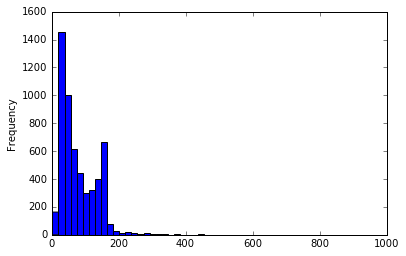

In [22]:
messages.length.plot(bins=50, kind='hist')

In [23]:
messages.length.describe()

count    5572.000000
mean       80.616296
std        60.015593
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [24]:
messages.message[messages.length>900]

1085    For me the love should start with attraction.i...
Name: message, dtype: object

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf5c0fc850>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fcf5599e090>], dtype=object)

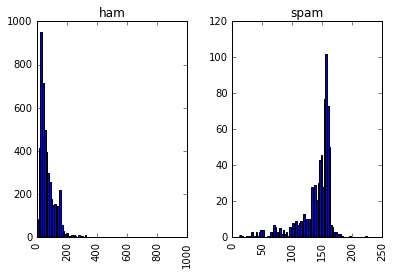

In [26]:
messages.hist(column='length', by='label',bins=80)

In [28]:
# Data preprocessing# bag-of-words approach

In [29]:
def split_into_tokens(message):
    message = unicode(message, 'utf8')
    return TextBlob(message).words

In [36]:
messages.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [37]:
# Gave error, executed following command to install punkt, snapshot in foler
#import nltk
#nltk.download()
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

In [42]:
TextBlob("Hi there, how have you been doing?").tags

[('Hi', u'NNP'),
 ('there', u'RB'),
 ('how', u'WRB'),
 ('have', u'VBP'),
 ('you', u'PRP'),
 ('been', u'VBN'),
 ('doing', u'VBG')]

In [43]:
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    return [word.lemma for word in words]

In [46]:
# Lemmentization
messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

In [45]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [47]:
# Data to vectors, TF vector, IDF vector, L2 norm.

In [50]:
btransformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])

# This is our vocabulary
# btransformer.vocabulary_
len(btransformer.vocabulary_)

8874

In [57]:
sms5=messages['message'][4]
sms5

"Nah I don't think he goes to usf, he lives around here though"

In [62]:
bow5 = btransformer.transform([sms5])
print bow5

  (0, 1320)	1
  (0, 2773)	1
  (0, 3632)	1
  (0, 3862)	2
  (0, 3919)	1
  (0, 4102)	1
  (0, 4718)	1
  (0, 5326)	1
  (0, 5338)	1
  (0, 7720)	1
  (0, 7739)	1
  (0, 7812)	1
  (0, 8150)	1


In [67]:
# checl 3862 from vocab
btransformer.get_feature_names()[3862]

u'he'

In [70]:
sms_bow = btransformer.transform(messages['message'])
print 'sparse matrix shape: ', sms_bow.shape
print 'num of non-zeros: ', sms_bow.nnz

sparse matrix shape:  (5572, 8874)
num of non-zeros:  80271


In [74]:
print 'sparsity: ',(100.0*sms_bow.nnz/(sms_bow.shape[0]*sms_bow.shape[1]))

sparsity:  0.162340971738


In [75]:
tfidf_transformer=TfidfTransformer().fit(sms_bow)
tfidf5 = tfidf_transformer.transform(bow5)

<1x8874 sparse matrix of type '<type 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [76]:
print tfidf5

  (0, 8150)	0.365290644519
  (0, 7812)	0.11228549846
  (0, 7739)	0.323807062521
  (0, 7720)	0.238173875773
  (0, 5338)	0.369741759448
  (0, 5326)	0.200798081571
  (0, 4718)	0.274347675603
  (0, 4102)	0.102893080257
  (0, 3919)	0.247500635462
  (0, 3862)	0.463041872688
  (0, 3632)	0.202538234079
  (0, 2773)	0.178208105786
  (0, 1320)	0.284693213932


In [90]:
# E.g. find tfidf of 'hello'
tfidf_transformer.idf_[btransformer.vocabulary_['hello']]

5.8190262977992164

In [92]:
# Calculate tfidf of entire document. just like we calculated sparse matrix.
sms_tfidf = tfidf_transformer.transform(sms_bow)
sms_tfidf.shape

(5572, 8874)

In [96]:
# Now use a classifier algorithm, we use Naive bayes
%time spam_detector = MultinomialNB().fit(sms_tfidf, messages['label'])

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 19 ms



In [99]:
print 'predicted: ', spam_detector.predict(tfidf5)
print 'expected: ', messages.label[4]

predicted:  ['ham']
expected:  ham


In [100]:
sms_prediction = spam_detector.predict(sms_tfidf)
sms_prediction

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], 
      dtype='|S4')

In [104]:
# Calculate accuracy and confusion matrix
print 'accuracy', accuracy_score(messages['label'], sms_prediction); print ' '
print 'confusion matrix \n \n', confusion_matrix(messages['label'], sms_prediction)

accuracy 0.969490308686
 
confusion matrix 
 
[[4825    0]
 [ 170  577]]


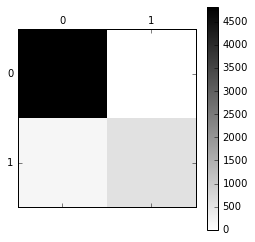

In [107]:
plt.matshow(confusion_matrix(messages['label'],sms_prediction), cmap=plt.cm.binary, interpolation='nearest')
plt.colorbar()

In [109]:
# Now lets train the calssifier using training data and then test using rest of the data
msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'],test_size=0.2)
print len(msg_train), len(msg_test)

4457 1115


In [112]:
# using pipeline, transormation and prediction can be done in 1 step i.e. transform and transform and finally predict 
pipeline=Pipeline([('bow', CountVectorizer(analyzer=split_into_lemmas)),('tfidf', TfidfTransformer()),('classifier',MultinomialNB())])
# 1) String to tokens, then tfidf and then train NB C.

In [116]:
scores = cross_val_score(pipeline, msg_train, label_train, cv=10,scoring='accuracy', n_jobs=-1)
print scores,'/n', scores.mean(), scores.std()

[ 0.95525727  0.94618834  0.94170404  0.94618834  0.95515695  0.94843049
  0.95280899  0.95955056  0.95280899  0.95730337] /n 0.951539734224 0.00539631703636
